In [2]:
import xara
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
import ExoRIM as exo
import tensorflow as tf
from celluloid import Camera
from IPython.display import HTML
from matplotlib.lines import Line2D
from joypy import joyplot
import pandas as pd
tf.keras.backend.set_floatx('float32')
%matplotlib inline

In [253]:
# Defines physical variables
N = 21
L = 6
pixels = 64
wavel = 0.5e-6
plate_scale = 0.2 #2.2 * 1000 / 2048 * 3 # James Webb plate scale, #exo.definitions.rad2mas(1.22 * wavel / 4 / L)/10 # mas / pixel at the diffraction limit
var = 1
ISZ = 32  # number of pixels for the image

In [118]:
# circle_mask = np.zeros((21, 2))
# for i in range(21):
#     circle_mask[i,0] = (100 + 10*np.random.normal())*np.cos(2*np.pi*i/21)
#     circle_mask[i,1] = (100 + 10*np.random.normal())*np.sin(2*np.pi*i/21)
mask = np.array([[5, 0], [-5, 0]])
kpi = xara.KPI(array=mask)

Attempting to build KPI from array None
1 distinct baselines were identified
10 first singular values for this array:
[1.]

        Summary of properties for no_name
        ---------------------------------------------------------------
        -   2 sub-apertures
        -   1 distinct baselines
        -   0 Ker-phases ( 0.0 % target phase information recovery)
        -   1 Eig-phases (50.0 % wavefront information recovery)
        ---------------------------------------------------------------
        
KPI data successfully created


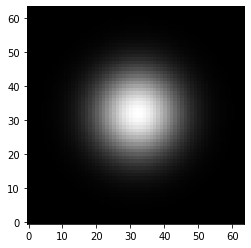

In [254]:
image_coords = np.arange(pixels) - pixels / 2.
xx, yy = np.meshgrid(image_coords, image_coords)
image1 = np.zeros_like(xx)
rho_squared = (xx) ** 2 + (yy) ** 2
image1 += np.exp(-rho_squared/12**2)
# rho_squared = (xx - 7) ** 2 + (yy - 7) ** 2
# image1 += np.exp(-rho_squared/5**2)
# image1 += (xx - 30) ** 2 + (yy - 30) ** 2 < 10
plt.imshow(image1, cmap="gray")

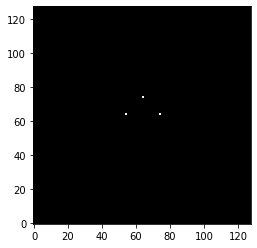

In [205]:
# Visualization of 3 sub aperture intereference
image_coords = np.arange(128) - 128 / 2.
xx, yy = np.meshgrid(image_coords, image_coords)
image = np.zeros_like(xx)
rho = np.sqrt((xx-5) ** 2 + (yy) ** 2)
image += np.sqrt((xx-10) ** 2 + (yy) ** 2) < 1
image += np.sqrt((xx+10) ** 2 + (yy) ** 2) < 1
image += np.sqrt((xx) ** 2 + (yy-10) ** 2) < 1
plt.imshow(image, cmap="gray")

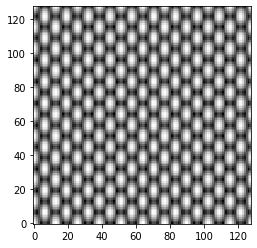

In [206]:
image_hat = np.fft.fft2(image)
plt.imshow(np.abs(image_hat), cmap="gray")

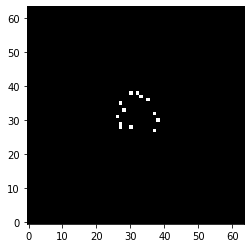

In [255]:
x = (L + np.random.normal(0, var, N)) * np.cos(2 * np.pi * np.arange(N) / N)
y = (L + np.random.normal(0, var, N)) * np.sin(2 * np.pi * np.arange(N) / N)
circle_mask = np.array([x, y]).T
image_coords = np.arange(pixels) - pixels / 2.
xx, yy = np.meshgrid(image_coords, image_coords)
image = np.zeros_like(xx)
for x in circle_mask:
    rho_squared = np.sqrt((xx-x[0]) ** 2 + (yy - x[1]) ** 2)
    image += np.sqrt(rho_squared) < 0.7
mask = np.random.normal(0, L, (N, 2))
plt.imshow(image, cmap="gray")

In [256]:
def bispectra(V):
    V1 = tf.einsum("ij, ...j -> ...i", V1_projector, V)
    V2 = tf.einsum("ij, ...j -> ...i", V2_projector, V)
    V3 = tf.einsum("ij, ...j -> ...i", V3_projector, V)
    return V1 * tf.math.conj(V2) * V3  # hack that works with baseline class! Be careful using other method

def zero_pad(image):
    return np.pad(image, pixels//2, 'constant', constant_values=0)

def zero_pad_over_batch(images):
    out = np.zeros((images.shape[0], 2*pixels, 2*pixels))
    out[:, pixels//2:-pixels//2, pixels//2:-pixels//2] = images 
    return out

def crop_image(image):
    return image[..., pixels//2:-pixels//2, pixels//2:-pixels//2]

# Test with zero padding

# B = exo.operators.Baselines(circle_mask)
B = exo.operators.Baselines(circle_mask)
print(plate_scale)
print(exo.definitions.rad2mas(1.22 * wavel / 4 / L))
ndftm = exo.operators.NDFTM(B.UVC, wavel, pixels, plate_scale)
ndftm_i = exo.operators.NDFTM(B.UVC, wavel, pixels, plate_scale, inv=True)
p = N * (N - 1) // 2
# q = (N - 1) * (N - 2) // 2
q = N * (N - 1) * (N - 2) // 6
mycomplex = exo.definitions.mycomplex
dtype = exo.definitions.dtype
baselines = exo.operators.Baselines(mask_coordinates=circle_mask)
# CPO = exo.operators.phase_closure_operator(baselines)
CPO = exo.operators.redundant_phase_closure_operator(baselines)
bisp_i = np.where(CPO != 0)
V1_i = (bisp_i[0][0::3], bisp_i[1][0::3])
V2_i = (bisp_i[0][1::3], bisp_i[1][1::3])
V3_i = (bisp_i[0][2::3], bisp_i[1][2::3])
V1_projector_np = np.zeros(shape=(q, p))
V1_projector_np[V1_i] += 1.0
V1_projector = tf.constant(V1_projector_np, dtype=mycomplex)
V2_projector_np = np.zeros(shape=(q, p))
V2_projector_np[V2_i] += 1.0
V2_projector = tf.constant(V2_projector_np, dtype=mycomplex)
V3_projector_np = np.zeros(shape=(q, p))
V3_projector_np[V3_i] += 1.0
V3_projector = tf.constant(V3_projector_np, dtype=mycomplex)
CPO = tf.constant(CPO, dtype=dtype)
A = tf.constant(ndftm, dtype=mycomplex)
# Discrete Fourier Transform Matrices for bispectra
A1 = tf.tensordot(V1_projector, A, axes=1)
A2 = tf.tensordot(V2_projector, A, axes=1)
A3 = tf.tensordot(V3_projector, A, axes=1)

210 distinct baselines found. Mask has 0 redundant baselines
0.2
5.242563825447032
210 distinct baselines found. Mask has 0 redundant baselines
There are 190 independant closure phases and 1330 total closure phases


163.06979157892735

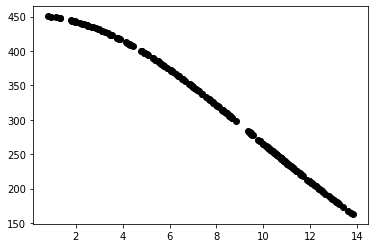

In [257]:

# V = ndftm.dot(zero_pad(image1).flatten())
V = ndftm.dot(image1.flatten())
phase_noise = np.random.normal(0, np.pi/3, size=[B.nbap])
visibility_phase_noise = np.einsum("ij, ...j -> ...i", B.BLM, phase_noise)

noisy_V = V * np.exp(1j * visibility_phase_noise)
psi = np.einsum("ij, ...j -> ...i", CPO.numpy(), np.angle(V))
noisy_psi = np.einsum("ij, ...j -> ...i", CPO.numpy(), np.angle(noisy_V))

Bisp = bispectra(V)
NoisyBisp = bispectra(noisy_V)


bas = np.sqrt(B.UVC[:, 0]**2 + B.UVC[:, 1]**2)
plt.plot(bas, np.abs(V), "ko")
np.abs(V).min()

B = V1 * V2.conj() * V3

Bispectra angles


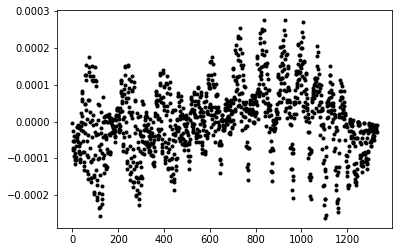

In [258]:

plt.plot(np.arange(Bisp.numpy().size), tf.math.angle(Bisp).numpy(), "k.")
print("Bispectra angles")

Noisy Bispectra angles


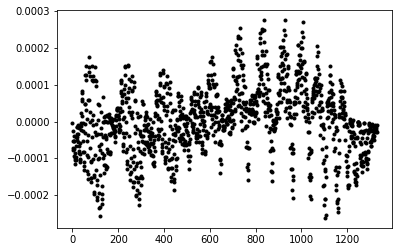

In [259]:
plt.plot(np.arange(NoisyBisp.numpy().size), tf.math.angle(NoisyBisp).numpy(), "k.")
print("Noisy Bispectra angles")

Diff


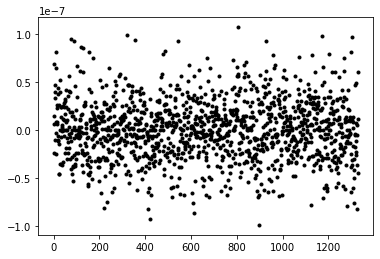

In [260]:
plt.plot(np.arange(NoisyBisp.numpy().size), tf.math.angle(NoisyBisp).numpy() - tf.math.angle(Bisp).numpy(), "k.")
print("Diff")

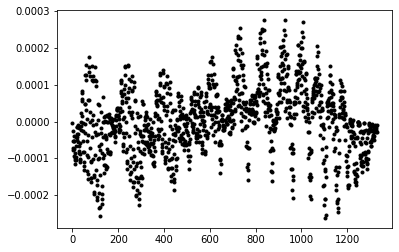

In [261]:
plt.plot(np.arange(psi.size), psi, "k.")

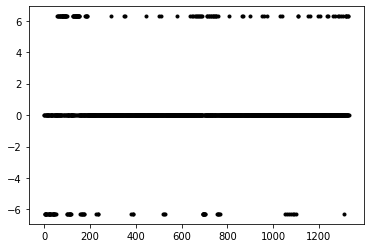

In [262]:
plt.plot(np.arange(noisy_psi.size), noisy_psi, "k.")

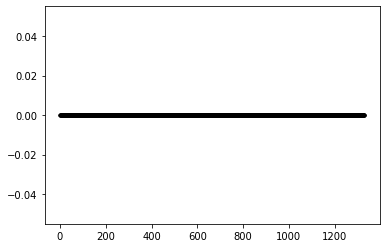

In [215]:
plt.plot(np.arange(psi.size), 1 - np.cos(noisy_psi - psi), "k.")

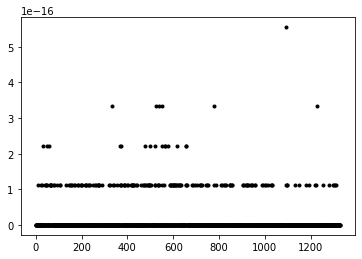

In [216]:
plt.plot(np.arange(psi.size), 1 - np.cos(psi - tf.math.angle(Bisp).numpy()), "k.")

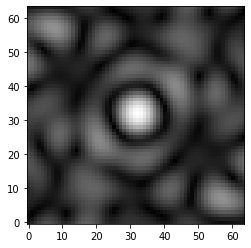

In [217]:
image_hat = np.fft.fftshift(np.fft.fft2(zero_pad(image)))[pixels//2:-pixels//2, pixels//2:-pixels//2]
plt.imshow(np.abs(image_hat), cmap="gray")

In [57]:
def cast_to_complex_flatten(image):
    im = tf.dtypes.cast(image, mycomplex)
    im = tf.keras.layers.Flatten(data_format="channels_last")(im)
    return im

In [30]:

def chisq_amp(image, A, amp, sigma):
    """Visibility Amplitudes (normalized) chi-squared"""
    sig = tf.cast(sigma, dtype)
    im = cast_to_complex_flatten(image)
    #amp_samples = tf.math.abs(tf.einsum("ij, ...j -> ...i", A, im))
    amp_samples = tf.einsum("ij, ...j -> ...i", A, im)
    amp_samples = amp_samples #* tf.math.exp(-1j * tf.math.angle(amp_samples[0]))
    amp_samples = tf.math.abs(amp_samples)
    return tf.math.reduce_mean(((amp - amp_samples)/sig)**2, axis=1)

def chisqgrad_amp(image, V, sigma, floor=1e-6):
    """The gradient of the amplitude chi-squared"""
    pix = pixels # since we zero pad
    amp = tf.cast(tf.math.abs(V), dtype)
    im = cast_to_complex_flatten(image)
    V_samples = tf.einsum("ij, ...j -> ...i", A, im)
    amp_samples = tf.math.abs(V_samples)
    den = tf.cast((sigma + floor)**2, dtype)
    product = (amp - amp_samples) / den / amp_samples
    product = tf.cast(product, mycomplex)
    adjoint = tf.transpose(tf.math.conj(A))
    out = -2.0 * tf.math.real(tf.einsum("ij, ...j -> ...i", adjoint, V_samples * product))
    out = tf.reshape(out, shape=[-1, pix, pix, 1])
    return out / amp.shape[1]

In [167]:
def chisq_bis(image, B, sigma):
    """

    :param image: Image tensor
    :param Amatrices:
    :param B: Bispectrum projection matrix to project from complex visibilities to bispectrum ()
    :param bis:
    :param sigma:
    :return:
    """
    sig = tf.cast(sigma, dtype)
    im = cast_to_complex_flatten(image)
    V1 = tf.einsum("ij, ...j -> ...i", A1, im)
    V2 = tf.einsum("ij, ...j -> ...i", A2, im)
    V3 = tf.einsum("ij, ...j -> ...i", A3, im)
    B_sample = V1 * tf.math.conj(V2) * V3
    chisq = 0.5 * tf.reduce_mean(tf.math.square(tf.math.abs(B - B_sample)/sig), axis=1)
    return chisq

def chisqgrad_bis(image, B, sigma, floor=1e-6):
    """The gradient of the bispectrum chi-squared"""
    pix = pixels
    sig = tf.cast(sigma, mycomplex)
    im = cast_to_complex_flatten(image)
    einsum = "ij, ...j -> ...i"
    t_einsum = "ji, ...j -> ...i"
    V1 = tf.einsum(einsum, A1, im)
    V2 = tf.einsum(einsum, A2, im)
    V3 = tf.einsum(einsum, A3, im)
    B_samples = V1 * tf.math.conj(V2) * V3
    wdiff = (B - B_samples)/(sig + floor)**2
    out = tf.einsum(t_einsum, tf.math.conj(A1), wdiff * tf.math.conj(V2 * V3))
    out += tf.einsum(t_einsum, A2, wdiff * V1 * V3)
    out += tf.einsum(t_einsum, tf.math.conj(A3), wdiff * tf.math.conj(V1 * V2))
    out = -tf.math.real(out) / B.shape[1]
    out = tf.reshape(out, shape=[-1, pix, pix, 1])
    return out


In [32]:
def chisq_cphase(image, clphase, sigma):
    """Closure Phases (normalized) chi-squared"""
    sig = tf.cast(sigma, dtype)
    im = cast_to_complex_flatten(image)
    einsum = "ij, ...j -> ...i"
    V1 = tf.einsum(einsum, A1, im)
    V2 = tf.einsum(einsum, A2, im)
    V3 = tf.einsum(einsum, A3, im)
    clphase_samples = tf.math.angle(V1 * tf.math.conj(V2) * V3)
    chisq = tf.reduce_mean(((1 - tf.math.cos(clphase - clphase_samples)) / sig)**2, axis=1)
    return chisq

def gradchisq_cphase_auto(image, vis, sigma):
    im = tf.constant(image, dtype)
    with tf.GradientTape() as tape:
        tape.watch(im)
        chisq = chisq_cphase(im, tf.math.angle(bispectra(vis)), sigma)
    return tape.gradient(chisq, im)

def chisqgrad_cphase(image, clphase, sigma):
    """The gradient of the closure phase chi-squared"""
    pix = pixels
    im = cast_to_complex_flatten(image)
    einsum = "ij, ...j -> ...i"
    t_einsum = "ji, ...j -> ...i"
    V1 = tf.einsum(einsum, A1, im)
    V2 = tf.einsum(einsum, A2, im)
    V3 = tf.einsum(einsum, A3, im)
    B = V1 * tf.math.conj(V2) * V3
    clphase_samples = tf.math.angle(B)
    wdiff = tf.cast(tf.math.sin(clphase - clphase_samples)/sigma**2, mycomplex)
    out = tf.einsum(t_einsum, tf.math.conj(A1), wdiff / tf.math.conj(V1))
    out = out + tf.einsum(t_einsum, A2, wdiff / V2)
    out = out + tf.einsum(t_einsum, tf.math.conj(A3), wdiff / tf.math.conj(V3))
    out = -2. * tf.math.imag(out) / B.shape[1]
    out = tf.reshape(out, shape=[-1, pix, pix, 1])
    return out

In [101]:
def chisq_vis(image, A, vis, sigma):
    sig = tf.cast(sigma, dtype)
    im = cast_to_complex_flatten(image)
    samples = tf.einsum("ij, ...j -> ...i", A, im)
    chisq = 0.5 * tf.reduce_mean((tf.math.abs(samples - vis) / sig)**2, axis=1)
    return chisq


def gradchisq_vis(image, vis, sigma, floor=1e-6):
    """The gradient of the visibility chi-squared"""
    pix = pixels
    sig = tf.cast(sigma + floor, mycomplex)  # prevent dividing by zero
    im = cast_to_complex_flatten(image)
    samples = tf.einsum("ij, ...j -> ...i", A, im)
    wdiff = (vis - samples)/(sig**2)
    out = -tf.math.real(tf.einsum("ji, ...j -> ...i", tf.math.conj(A), wdiff))
    out = tf.reshape(out, [-1, pix, pix, 1])
    return out / vis.shape[1]

def gradchisq_vis_auto(image, vis, sigma):
    im = tf.constant(image, dtype)
    with tf.GradientTape() as tape:
        tape.watch(im)
        chisq = chisq_vis(im, A, vis, sigma)
    return tape.gradient(chisq, im)

In [34]:
def chisq_phases(image, A, vis, sigma):
    sig = tf.cast(sigma, dtype)
    im = cast_to_complex_flatten(image)
    samples = tf.einsum("ij, ...j -> ...i", A, im)
    chisq = 0.5 * tf.reduce_mean((tf.math.abs(samples - vis) / sig)**2, axis=1)
    return chisq

In [35]:
def chisq_real_image(image, A, vis, sigma_r, sigma_i=None):
    if sigma_i is None:
        sigma_i = sigma_r
    sig_i = tf.cast(sigma_i, tf.float32)
    sig_r = tf.cast(sigma_r, tf.float32)
    im = exo.definitions.cast_to_complex_flatten(image)
    samples = tf.einsum("ij, ...j -> ...i", A, im)
#     chisq = 0
    chisq_r = 0.5 * tf.reduce_mean(((tf.math.real(samples) - tf.cast(tf.math.real(vis), dtype)) / sig_r)**2, axis=1)
    chisq_i = 0.5 * tf.reduce_mean(((tf.math.imag(samples) - tf.cast(tf.math.imag(vis), dtype)) / sig_i)**2, axis=1)
    return (chisq_r, chisq_i)

def gradchisq_real_imag(image, A, vis, sigma_r, sigma_i=None):
    if sigma_i is None:
        sigma_i = sigma_r
    sig_i = tf.cast(sigma_i, tf.float64)
    sig_r = tf.cast(sigma_r, tf.float64)
    ima = tf.constant(image, tf.float64)
    with tf.GradientTape() as tape:
        tape.watch(ima)
#         im = exo.definitions.cast_to_complex_flatten(ima)
        samples = tf.einsum("ij, ...j -> ...i", tf.math.real(A), ima)
        chisq_r = 0.5 * tf.reduce_mean(((samples - tf.cast(tf.math.real(vis), tf.float64)) / sig_r)**2, axis=1)
    grad_real = tape.gradient(chisq_r, ima)
    with tf.GradientTape() as tape:
        tape.watch(ima)
#         im = exo.definitions.cast_to_complex_flatten(ima)
        samples = tf.einsum("ij, ...j -> ...i", tf.math.imag(A), tf.cast(ima, tf.float64 ))
        chisq_i = 0.5 * tf.reduce_mean(((samples - tf.cast(tf.math.imag(vis), tf.float64)) / sig_i)**2, axis=1)
    grad_imag = tape.gradient(chisq_i, ima)
    return grad_real, grad_imag

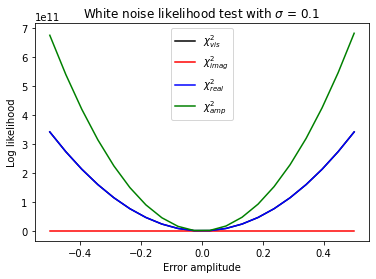

In [263]:
batch = 20
# im_copies = zero_pad(image1).flatten().reshape((1, 4*image1.shape[0]**2)) 
im_copies = image1.flatten().reshape((1, image1.shape[0]**2)) 
im_copies = np.tile(im_copies, [batch, 1])
V_copies = V.reshape((1, V.shape[0]))
V_copies = np.tile(V_copies, [batch, 1])
V_copies = tf.cast(V_copies, exo.definitions.mycomplex)
B = bispectra(V_copies)
noise = im_copies + np.linspace(-50, 50, batch).reshape((batch, 1))
sigma = 0.1
log_likelihood = chisq_vis(noise, ndftm, V_copies, sigma).numpy()
llr, lli = chisq_real_image(noise, ndftm, V_copies, sigma)
chi_amp = chisq_amp(noise, ndftm, tf.math.abs(V_copies), sigma)
chi_bis = chisq_bis(noise, bispectra(V), sigma)
mse = np.mean((noise - im_copies)**2, axis=1)
plt.plot(np.linspace(-50, 50, batch) / 100, log_likelihood, color="k", label=r"$\chi^2_{vis}$")
plt.plot(np.linspace(-50, 50, batch) / 100, lli.numpy(), color="r", label=r"$\chi^2_{imag}$")
plt.plot(np.linspace(-50, 50, batch) / 100, llr.numpy(), color="b", label=r"$\chi^2_{real}$")
plt.plot(np.linspace(-50, 50, batch) / 100, chi_amp.numpy(), color="g", label=r"$\chi^2_{amp}$")
# plt.plot(np.linspace(-50, 50, 100) / 100, chi_bis.numpy(), color="m", label=r"$\chi^2_{bis}$")  # Some 10 order of magnitude higher! Swamps the signal from amp
# plt.plot(np.linspace(-50, 50, 100) / 100, mse, color="b", label=r"$\chi^2_{real}$")
plt.xlabel("Error amplitude")
plt.ylabel("Log likelihood")
plt.title(rf"White noise likelihood test with $\sigma$ = {sigma}")
plt.legend()
plt.savefig("chisq_vs_error_amp.png")

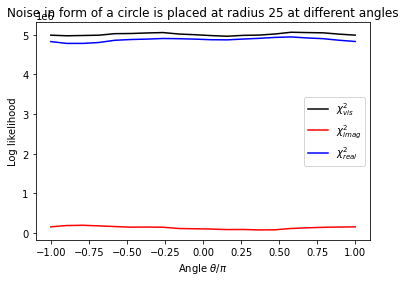

In [264]:
# Add a random circle in the image - first by angle, then by radius, then x then y
angle = np.linspace(-np.pi, np.pi, batch)
r = 25
x_prime = r * np.cos(angle)
y_prime = r * np.sin(angle)
noise = np.zeros((batch, pixels, pixels))
for i in range(batch):
    rho = np.sqrt((xx - x_prime[i]) ** 2 + (yy - y_prime[i]) ** 2)
    noise[i] += rho < 5
# noise = zero_pad_over_batch(noise)
# noise = noise.reshape(batch, 4*pixels**2)
noise = noise.reshape(batch, pixels**2)
log_likelihood = chisq_vis(noise, ndftm, V_copies, 0.1).numpy()
llr, lli = chisq_real_image(noise, ndftm, V_copies, 0.1)
plt.plot(angle / np.pi, log_likelihood, color="k", label=r"$\chi^2_{vis}$")
plt.plot(angle / np.pi, lli.numpy(), color="r", label=r"$\chi^2_{imag}$")
plt.plot(angle / np.pi, llr.numpy(), color="b", label=r"$\chi^2_{real}$")
plt.xlabel(r"Angle $\theta/ \pi$")
plt.ylabel("Log likelihood")
plt.title(f"Noise in form of a circle is placed at radius {r} at different angles")
# plt.text(1, 0.5, rf"Noise amplitude: $\sigma$ = {sigma}", fontsize=14, transform=plt.gcf().transFigure)
plt.legend()
plt.savefig("chisq_vs_circle_at_different_angles.png")

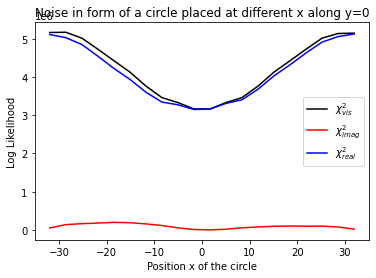

In [265]:
x_prime = np.linspace(-pixels/2, pixels/2, batch)
y_prime = [0 for i in range(batch)]
noise = np.zeros((batch, pixels, pixels))
for i in range(batch):
    rho = np.sqrt((xx - x_prime[i]) ** 2 + (yy - y_prime[i]) ** 2)
    noise[i] += rho < 5
# noise = zero_pad_over_batch(noise)
# noise = noise.reshape(batch, 4*pixels**2)
noise = noise.reshape(batch, pixels**2)
log_likelihood = chisq_vis(noise, ndftm, V_copies, 0.1).numpy()
llr, lli = chisq_real_image(noise, ndftm, V_copies, 0.1)
mse = np.mean((noise - im_copies)**2, axis=1)
plt.plot(x_prime, log_likelihood, color="k", label=r"$\chi^2_{vis}$")
plt.plot(x_prime, lli.numpy(), color="r", label=r"$\chi^2_{imag}$")
plt.plot(x_prime, llr.numpy(), color="b", label=r"$\chi^2_{real}$")
# plt.plot(x_prime, mse)
plt.xlabel(f"Position x of the circle")
plt.ylabel("Log Likelihood")
plt.title(rf"Noise in form of a circle placed at different x along y=0")
# plt.text(1, 0.5, rf"Noise amplitude: $\sigma$ = {sigma}", fontsize=14, transform=plt.gcf().transFigure)
plt.legend()
plt.savefig("chisq_vs_circle_at_different_x.png")

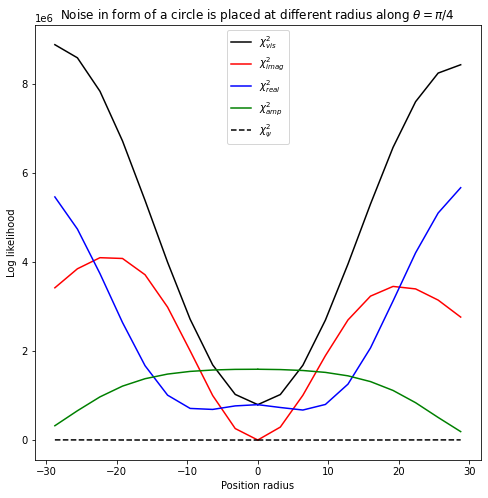

In [266]:
angle = np.array([5 * np.pi/4 for i in range(batch//2)] + [np.pi/4 for i in range(batch//2)])
r = np.array(list(range(batch//2))[::-1] + list(range(batch//2))) * pixels/batch
x_prime = r * np.cos(angle)
y_prime = r * np.sin(angle)
noise = np.zeros((batch, pixels, pixels))
for i in range(batch):
    rho = np.sqrt((xx - x_prime[i]) ** 2 + (yy - y_prime[i]) ** 2)
    noise[i] += np.exp(-rho**2/15**2)
# noise = zero_pad_over_batch(noise)
# noise = noise.reshape(batch, 4*pixels**2)
noise = noise.reshape(batch, pixels**2)
log_likelihood = chisq_vis(noise, ndftm, V_copies, 0.1).numpy()
llr, lli = chisq_real_image(noise, ndftm, V_copies, 0.1)
chi_amp = chisq_amp(noise, ndftm, tf.math.abs(V_copies), 0.1)
chi_bis = chisq_bis(noise, bispectra(V_copies), 0.1)
chi_cp = chisq_cphase(noise, tf.math.angle(bispectra(V_copies)), 1e-4)
plt.figure(figsize=(8, 8))
plt.plot(r[batch//2:], log_likelihood[batch//2:], color="k", label=r"$\chi^2_{vis}$")
plt.plot(-r[:batch//2], log_likelihood[:batch//2], color="k")
plt.plot(r[batch//2:], lli.numpy()[batch//2:], color="r")
plt.plot(-r[:batch//2], lli.numpy()[:batch//2], color="r", label=r"$\chi^2_{imag}$")
plt.plot(r[batch//2:], llr.numpy()[batch//2:], color="b")
plt.plot(-r[:batch//2], llr.numpy()[:batch//2], color="b", label=r"$\chi^2_{real}$")
plt.plot(r[batch//2:], chi_amp.numpy()[batch//2:], color="g")
plt.plot(-r[:batch//2], chi_amp.numpy()[:batch//2], color="g", label=r"$\chi^2_{amp}$")
# plt.plot(r[batch//2:], chi_bis.numpy()[batch//2:], color="m")
# plt.plot(-r[:batch//2], chi_bis.numpy()[:batch//2], color="m", label=r"$\chi^2_{bis}$")
plt.plot(r[batch//2:], chi_cp.numpy()[batch//2:], "--", color="k")
plt.plot(-r[:batch//2], chi_cp.numpy()[:batch//2] , "--", color="k", label=r"$\chi^2_{\psi}$")
plt.xlabel(f"Position radius")
plt.ylabel("Log likelihood")
plt.title(rf"Noise in form of a circle is placed at different radius along $\theta=\pi/4$")
# plt.text(1, 0.5, rf"Noise amplitude: $\sigma$ = {sigma}", fontsize=14, transform=plt.gcf().transFigure)
plt.legend()
plt.savefig("chisq_vs_circle_different_radius_zoomed.png", bbox_inches="tight")

In [267]:
V_tf = tf.cast(tf.reshape(V, [1, -1]), mycomplex)
grad_r, grad_i = gradchisq_real_imag(noise, ndftm, V_tf, sigma)
grad_vis = gradchisq_vis(noise, V_tf, sigma)
grad_amp = chisqgrad_amp(noise, V_tf, sigma)
grad_bis = chisqgrad_bis(noise, bispectra(V_tf), sigma)
grad_cp = chisqgrad_cphase(noise, tf.math.angle(bispectra(V_tf)), 1e-4)
grad_cp_auto = gradchisq_cphase_auto(noise, V_tf, 1e-4)

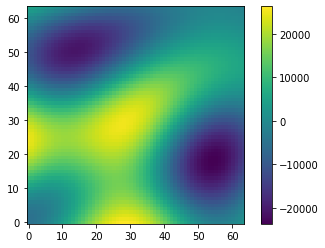

In [268]:
# grad_bis.shape
# plt.imshow(np.real(np.fft.fftshift(np.fft.fft2(grad_cp.numpy()[62, ..., 0]))))
# plt.imshow(np.real(np.fft.fftshift(np.fft.fft2(grad_bis.numpy()[50, ..., 0]))))
plt.imshow((1.*grad_amp.numpy()[..., 0] + 1*grad_cp.numpy()[..., 0])[4])
# plt.imshow(1.*grad_vis.numpy().reshape((batch, pixels, pixels))[19])
# plt.imshow(grad_amp.numpy()[..., 0][50])
plt.colorbar()
# grad_cp.numpy()

In [269]:
%%capture
chisq_dict = {
    r"$\chi^2_{vis}$" : [log_likelihood, "k"],
    r"$\chi^2_{imag}$": [lli.numpy(), "r"],
    r"$\chi^2_{real}$": [llr.numpy(), "b"]
}
fig, (grad, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 10), dpi=80)
# fig.suptitle(title)
cam = Camera(fig)
fig.tight_layout(pad=5.0)
ax2.set_ylabel("Log likelihood")
ax2.set_xlabel("r")
d = int(np.sqrt(noise.shape[1]))
#     handles = []
#     for key, item in chisq.items():
#         handles.append(Line2D([0], [0], color=item[1], label=key))
#     ax2.legend(handles, loc="upper right")
for i in range(noise.shape[0]):
    im = noise[i].reshape((d, d))
    grad.imshow(grad_cp[i].numpy().reshape((d, d)))
    ax1.imshow(im, cmap="gray")
    for key, item in chisq_dict.items():
        loss = item[0]
        color = item[1]
        ax2.plot(x_prime[:i+1], loss[:i+1], c=color, lw=2)
    cam.snap()
animation = cam.animate()
animation.save(f"gradchisq_cp.mp4", writer="ffmpeg")
anim = HTML(animation.to_html5_video())

In [270]:
anim

In [271]:
%%capture
chisq_dict = {
    r"$\chi^2_{vis}$" : [log_likelihood, "k"],
    r"$\chi^2_{imag}$": [lli.numpy(), "r"],
    r"$\chi^2_{real}$": [llr.numpy(), "b"],
    r"$\chi^2_{amp}$": [chi_amp.numpy(), "g"],
    r"$\chi^2_{\psi}$": [chi_cp.numpy()/1e5, "m"]
#     r"$\chi^2_{bis}$": [chi_bis.numpy(), "m"],
}
fig, axes = plt.subplots(3, 3, figsize=(30, 15), dpi=80)
# fig.suptitle(title)
cam = Camera(fig)
fig.tight_layout(pad=5.0)
axes[0, 2].set_ylabel("Log likelihood")
axes[0, 2].set_xlabel("Position x of the circle")
d = pixels
axes[0, 0].set_title("Ground truth")
axes[0, 1].set_title("Test image")
axes[1, 0].set_title(r"$\nabla_x\chi^2_{real}$")
axes[1, 1].set_title(r"$\nabla_x\chi^2_{imag}$")
axes[1, 2].set_title(r"$\nabla_x\chi^2_{vis}$")
axes[2, 0].set_title(r"$\nabla_x\chi^2_{amp}$")
axes[2, 1].set_title(r"$\nabla_x\chi^2_{bis}$")
axes[2, 2].set_title(r"$\nabla_x\chi^2_{\psi}$")
handles = []
for key, item in chisq_dict.items():
        handles.append(Line2D([0], [0], color=item[1], label=key))
axes[0, 2].legend(handles=handles, loc="upper right")
for i in range(noise.shape[0]):
    im = noise[i].reshape((d, d))
    axes[0, 0].imshow(image1, cmap="gray")
    axes[0, 1].imshow(im, cmap="gray")
    for key, item in chisq_dict.items():
        loss = item[0]
        color = item[1]
        axes[0, 2].plot(x_prime[:i+1], loss[:i+1], c=color, lw=2)
    axes[1, 0].imshow(grad_r[i].numpy().reshape((d, d)))
    axes[1, 1].imshow(grad_i[i].numpy().reshape((d, d)))
    axes[1, 2].imshow(grad_vis[i].numpy().reshape((d, d)))
    axes[2, 0].imshow(grad_amp[i].numpy().reshape((d, d)))
    axes[2, 1].imshow(grad_bis[i].numpy().reshape((d, d)))
    axes[2, 2].imshow(grad_cp[i].numpy().reshape((d, d)))
    cam.snap()
animation = cam.animate()
animation.save("all_chisq_grad_1.mp4", writer="ffmpeg")
anim2 = HTML(animation.to_html5_video())

In [272]:
anim2

In [ ]:
y_prime = np.linspace(-50, 50, 100)
x_prime = [0 for i in range(100)]
noise = np.zeros_like(im_copies.reshape(100, pixels, pixels))
for i in range(100):
    rho = np.sqrt((xx - x_prime[i]) ** 2 + (yy - y_prime[i]) ** 2)
    noise[i] += rho < 10 * sigma * 10
noise = noise.reshape(100, pixels**2)
log_likelihood = exo.definitions.chisq_vis(noise, ndftm, V_copies, 0.1).numpy()
llr, lli = chisq_real_image(noise, ndftm, V_copies, 0.1)
plt.plot(y_prime, log_likelihood, color="k", label=r"$\chi^2_{vis}$")
plt.plot(y_prime, lli.numpy(), color="r", label=r"$\chi^2_{imag}$")
plt.plot(y_prime, llr.numpy(), color="b", label=r"$\chi^2_{real}$")
plt.xlabel(f"Position y of the circle")
plt.ylabel("Log likelihood")
plt.title(rf"Noise in form of a circle placed at different x along x = 0")
# plt.text(1, 0.5, rf"Noise amplitude: $\sigma$ = {sigma}", fontsize=14, transform=plt.gcf().transFigure)
plt.legend()
plt.savefig("chisq_vs_circle_at_different")

In [ ]:
noise = np.zeros_like(im_copies.reshape(100, pixels, pixels))
rho = np.sqrt((xx - 20) ** 2 + (yy - 20) ** 2)
r = np.linspace(1, 60, 100)
for i in range(100):
    noise[i] += rho < r[i]
noise = noise.reshape(100, pixels**2)
log_likelihood = exo.definitions.chisq_vis(noise, ndftm, V_copies, 0.1).numpy()
llr, lli = chisq_real_image(noise, ndftm, V_copies, 0.1)
mse = np.mean((noise - im_copies)**2, axis=1)
plt.plot(r, log_likelihood, color="k", label=r"$\chi^2_{vis}$")
plt.plot(r, lli.numpy(), color="r", label=r"$\chi^2_{imag}$")
plt.plot(r, llr.numpy(), color="b", label=r"$\chi^2_{real}$")
# plt.plot(r, mse)
plt.xlabel(f"Radius of circle")
plt.ylabel("Log Likelihood")
plt.title(rf"Noise in form of a circle placed at different x along y=0")
# plt.text(1, 0.5, rf"Noise amplitude: $\sigma$ = {sigma}", fontsize=14, transform=plt.gcf().transFigure)
plt.legend()
plt.savefig("chisq_vs_circle_of different_sizepng")

In [ ]:
noise = np.zeros_like(im_copies.reshape(100, pixels, pixels))
sigma = 0.1
sig = np.linspace(.01, 1, 100)
for i in range(100):
    noise[i] += np.random.normal(1, sig[i], size=(N, N))
noise = noise.reshape(100, pixels**2)
log_likelihood = exo.definitions.chisq_vis(noise, ndftm, V_copies, 0.1).numpy()
llr, lli = chisq_real_image(noise, ndftm, V_copies, 0.1)
mse = np.mean((noise - im_copies)**2, axis=1)
plt.plot(sig, log_likelihood, color="k", label=r"$\chi^2_{vis}$")
plt.plot(sig, lli.numpy(), color="r", label=r"$\chi^2_{imag}$")
plt.plot(sig, llr.numpy(), color="b", label=r"$\chi^2_{real}$")
# plt.plot(sig, mse)
plt.xlabel(fr"$\sigma$")
plt.ylabel("Log Likelihood")
plt.title(rf"Noise in form of a circle placed at different x along y=0")
# plt.text(1, 0.5, rf"Noise amplitude: $\sigma$ = {sigma}", fontsize=14, transform=plt.gcf().transFigure)
plt.legend()
plt.savefig("white_noise_of_different_sigma.png")

In [ ]:
grad_r, grad_i = gradchisq_real_imag(noise, ndftm, V, sigma)
grad_vis_1 = exo.definitions.chisqgrad_vis(noise, tf.cast(ndftm, tf.complex64), V, sigma, pixels, floor=1e-6)
grad_vis_2 = gradchisq_vis(noise, tf.cast(ndftm, tf.complex64), V, sigma)

In [ ]:
%%capture
anim3 = movie_with_grad(image1, noise,  grad_r.numpy(), grad_i.numpy(), grad_vis_1.numpy(), grad_vis_2.numpy(), sig, 
      {r"$\chi^2_{vis}$" : [log_likelihood, "k"],
        r"$\chi^2_{imag}$": [lli.numpy(), "r"],
        r"$\chi^2_{real}$": [llr.numpy(), "b"]},
        mse,
      rf"White noise likelihood test", 
      "chisq_against_white_noise_of_different_sigma",
                        "sigma"
    )

In [ ]:
anim3